imports

In [1]:
from matplotlib import pyplot as plt
import itertools
from subgraph_matching_via_nn.data.paths import *
from subgraph_matching_via_nn.data.data_loaders import load_graph
from subgraph_matching_via_nn.graph_processors.graph_processors import GraphProcessor
import wwl
from igraph import Graph
from sklearn.metrics.pairwise import laplacian_kernel
import networkx as nx
import numpy as np
from networkx import NetworkXError
from notebooks import WL_metric
from subgraph_matching_via_nn.utils.utils import plot_graph_with_colors
from subgraph_matching_via_nn.utils.plot_services import PlotServices
import networkx as nx
import random
import matplotlib.pyplot as plt
from subgraph_matching_via_nn.utils.utils import get_node_indicator, get_edge_indicator
from subgraph_matching_via_nn.data.sub_graph import SubGraph


def generate_random_graph(n, k):
    if k > n * (n - 1) // 2:
        raise ValueError('Too many edges for the given number of nodes!')
    G = nx.Graph()
    G.add_nodes_from(range(n))
    while G.number_of_edges() < k:
        u, v = random.sample(G.nodes(), 2)  # Randomly sample two distinct nodes
        if not G.has_edge(u, v):
            G.add_edge(u, v)
    return G

def generate_subgraph(G, m):
    if m > G.number_of_edges():
        raise ValueError('Requested more edges than available in the graph!')
    # Randomly sample m edges
    selected_edges = random.sample(G.edges(), m)
    # Create a new graph from the selected edges
    G_sub = nx.Graph()
    G_sub.add_edges_from(selected_edges)
    return G_sub

define parameters

In [2]:
n = 10
m = 7

to_line = True
node_label_name = "label"# "node_label" #"label"

create full graph and GT sub graph

In [3]:
loader_params = {'graph_size': n,
                 'subgraph_size': m,
                 'data_path' : DATA_PATH,
                 'g_full_path': COMP1_FULL_path,
                 'g_sub_path': COMP1_SUB0_path}

# sub_graph = \
#     load_graph(type='random',
#                loader_params=loader_params) # type = 'random', 'example', 'subcircuit'

# Example usage:
n = 10
k = 13
G = generate_random_graph(n, k)

# Example usage:
m = 8
G_sub = generate_subgraph(G, m)

node_indicator = get_node_indicator(G=G, G_sub=G_sub)
edge_indicator, subgraph_adj_matrix = get_edge_indicator(G=G, G_sub=G_sub)

sub_graph = SubGraph(G, G_sub, node_indicator=node_indicator, edge_indicator=edge_indicator)

line graph transformation

In [4]:
graph_processor = GraphProcessor(params={'to_line':  to_line})
processed_sub_graph = graph_processor.pre_process(sub_graph)

processed_G = processed_sub_graph.G

G = processed_sub_graph.G
target_subgraph = processed_sub_graph.G_sub

extract all relevant sub graphs

In [5]:
graph_represnatation_nodes_amount = len(target_subgraph)

subgraphs_iterator = itertools.combinations(G, graph_represnatation_nodes_amount)
subgraphs = []

subgraph_counter = -1

for SG in (G.subgraph(s) for s in subgraphs_iterator):
    subgraph_counter += 1
    subgraphs.append(SG)
    # print(SG.nodes(), SG.edges())
    try:
        diff_graph = nx.difference(target_subgraph, SG)
    except NetworkXError:
        # node sets are different
        continue

    if nx.is_empty(diff_graph):
        print("match")
        target_subgraph_index = subgraph_counter

match


In [6]:
target_subgraph_index

427

In [7]:
len(subgraphs)

1287

compute wl embedding for all sub graphs

In [8]:
#TODO: version which does not entail all pairs

In [9]:
def get_graph_wl_distances(graphs, node_label):
    igraphs = [Graph() for i in range(len(graphs))]
    igraphs = [igraph.from_networkx(graph) for igraph, graph in zip(igraphs, graphs)]
    kernel_values = wwl.pairwise_wasserstein_distance(igraphs, enforce_continuous=True, num_iterations=10)
    kernel_values = laplacian_kernel(kernel_values) #normalize energey

    # gk_wl = WL_metric.GK_WL()
    # kernel_values = gk_wl.compare_list(graphs, h=5, node_label=node_label)

    return np.round(1 - kernel_values, decimals=4)

distance_matrix = get_graph_wl_distances(subgraphs + [target_subgraph], node_label=False)

Enforce continous flag is on, using CONTINUOUS propagation scheme.


compare histogram (embedding) with the GT sub graph

In [10]:
def get_distances_from_target_subgraph(distance_matrix, distance_threshold):
    all_subgraphs_vs_target_subgraph_distances = distance_matrix[:-1, -1]
    sorted_distances_enumeration = sorted(enumerate(all_subgraphs_vs_target_subgraph_distances), key=lambda x:x[1])
    sorted_distances_graph_indices = [i[0] for i in sorted_distances_enumeration]
    sorted_distances_graph_distances = [i[1] for i in sorted_distances_enumeration]

    graph_index_to_distance_map = dict(map(lambda i,j : (i,j) , sorted_distances_graph_indices,sorted_distances_graph_distances))
    # print(graph_index_to_distance_map)
    graph_index_to_distance_map = dict(filter(lambda item: item[1] <= distance_threshold, graph_index_to_distance_map.items()))

    return graph_index_to_distance_map

Plot distances

In [11]:
subgraph_index_to_distance_map = get_distances_from_target_subgraph(distance_matrix, distance_threshold=0.05)

In [12]:
subgraph_index_to_distance_map

{166: 0.0,
 177: 0.0,
 385: 0.0,
 418: 0.0,
 422: 0.0,
 425: 0.0,
 427: 0.0,
 505: 0.0,
 574: 0.0,
 712: 0.0,
 716: 0.0}

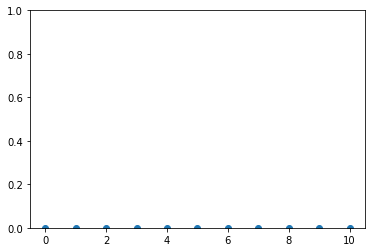

In [13]:
plt.scatter(range(len(subgraph_index_to_distance_map)), subgraph_index_to_distance_map.values())
plt.ylim(0, 1)
plt.show()

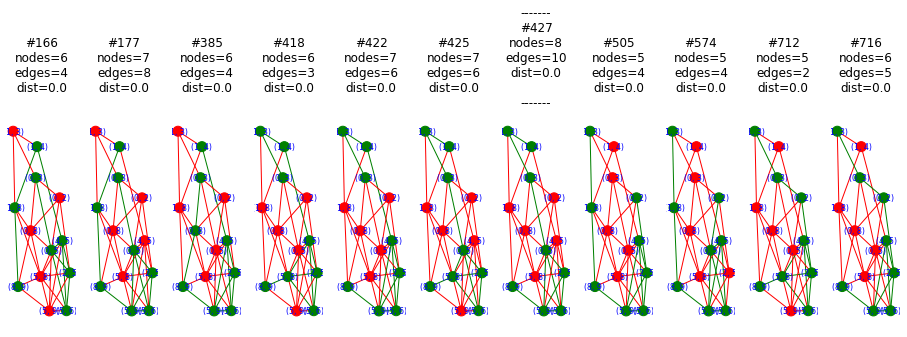

In [14]:
seed = 10  # for plotting
plot_services = PlotServices(seed)

fig, axes = plt.subplots(1, len(subgraph_index_to_distance_map), figsize=(16, 4))

axes_index = 0
for graph_index, distance in subgraph_index_to_distance_map.items():
    subgraph = subgraphs[graph_index]
    # target_subgraph
    intersected_graph = nx.intersection(target_subgraph, subgraph)
    n_nodes = len(intersected_graph.nodes)
    n_edges = len(intersected_graph.edges)

    title = f"#{graph_index}\nnodes={n_nodes}\nedges={n_edges}\ndist={distance}\n"
    if graph_index == target_subgraph_index:
        title = "-------\n" + title + "\n-------"

    plot_graph_with_colors(G=G, G_sub=subgraph, distribution=None, ax=axes[axes_index],
                           colorbar=False, title=title, seed=seed, draw_labels=True)
    axes_index += 1
plt.show()

In [15]:
len(distance_matrix)

1288

In [16]:
subgraph_index_to_distance_map = get_distances_from_target_subgraph(distance_matrix, distance_threshold=1.01)

In [17]:
length, path = nx.multi_source_dijkstra(G, set(target_subgraph.nodes))
subgraph_index_to_avg_node_distance_from_target_src_map = {}
for graph_index, distance in subgraph_index_to_distance_map.items():
    subgraph = subgraphs[graph_index]

    total_nodes_distances_from_target_subgraph_source_nodes = np.mean([length[node] for node in subgraph.nodes])
    # print(total_nodes_distances_from_target_subgraph_source_nodes)
    subgraph_index_to_avg_node_distance_from_target_src_map[graph_index] = total_nodes_distances_from_target_subgraph_source_nodes


In [18]:
# subgraph_index_to_distance_map
# subgraph_index_to_avg_node_distance_from_target_src_map

# subgraph_index_to_distance_map = sorted(subgraph_index_to_distance_map.items(), key=lambda x:x[0])
#
# sorted_subgraph_index_to_avg_node_distance_from_target_src = sorted(subgraph_index_to_avg_node_distance_from_target_src_map.items(), key=lambda x:x[0])

In [19]:
merged_dict = {k: (subgraph_index_to_distance_map[k], subgraph_index_to_avg_node_distance_from_target_src_map[k]) for k in subgraph_index_to_distance_map}

In [20]:
x, y = zip(*sorted(merged_dict.values(), key=lambda x:x[0]))

Text(0, 0.5, 'avg_node_distance_from_gt')

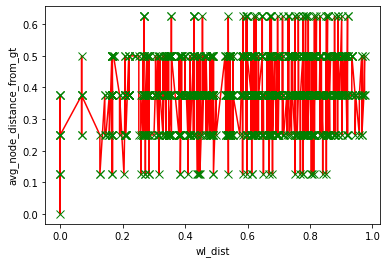

In [21]:
plt.plot(x, y, color='red', marker='x', markersize=8, markerfacecolor='green', markeredgecolor='green', linestyle='-')
plt.xlabel('wl_dist')
plt.ylabel('avg_node_distance_from_gt')

init color of full graph nodes with the subgraph mask weights

In [22]:
from scipy.spatial import ConvexHull
from collections import defaultdict


def split_to_y_bounds(x, y):
    # Group y values by x
    y_values_by_x = defaultdict(list)
    for xi, yi in zip(x, y):
        y_values_by_x[xi].append(yi)
    # Determine the minimum and maximum y values for each x
    x_unique = sorted(y_values_by_x.keys())
    y_min = [min(y_values_by_x[xi]) for xi in x_unique]
    y_max = [max(y_values_by_x[xi]) for xi in x_unique]
    return x_unique, y_min, y_max

def convex_hull(x, y):
    points = list(zip(x, y))
    # Calculate convex hull
    hull = ConvexHull(points)
    # Extract upper and lower envelopes
    upper_hull = [(x[hull.vertices[i]], y[hull.vertices[i]]) for i in range(hull.vertices.size) if y[hull.vertices[i]] >= x[hull.vertices[i]] * hull.equations[hull.vertices[i], 1] + hull.equations[hull.vertices[i], 2]]
    lower_hull = [(x[hull.vertices[i]], y[hull.vertices[i]]) for i in range(hull.vertices.size) if y[hull.vertices[i]] <= x[hull.vertices[i]] * hull.equations[hull.vertices[i], 1] + hull.equations[hull.vertices[i], 2]]
    # Unzip for plotting
    upper_x, upper_y = zip(*sorted(upper_hull, key=lambda t: t[0]))
    lower_x, lower_y = zip(*sorted(lower_hull, key=lambda t: t[0]))

    return lower_x, lower_y, upper_x, upper_y

In [23]:
x_unique, y_min, y_max = split_to_y_bounds(x, y)
# lower_x, lower_y, upper_x, upper_y = convex_hull(x, y)

# Sort points by x
sorted_points = sorted(zip(x, y))

# Function to get upper envelope
def upper_envelope(points):
    upper = [points[0]]
    for i in range(1, len(points)):
        while len(upper) >= 2 and (upper[-1][1] - upper[-2][1]) / (upper[-1][0] - upper[-2][0]) <= (points[i][1] - upper[-1][1]) / (points[i][0] - upper[-1][0]):
            upper.pop()
        upper.append(points[i])
    return zip(*upper)

# Function to get lower envelope
def lower_envelope(points):
    lower = [points[0]]
    for i in range(1, len(points)):
        while len(lower) >= 2 and (lower[-1][1] - lower[-2][1]) / (lower[-1][0] - lower[-2][0]) >= (points[i][1] - lower[-1][1]) / (points[i][0] - lower[-1][0]):
            lower.pop()
        lower.append(points[i])
    return zip(*lower)

# Extract envelopes
upper_x, upper_y = upper_envelope(sorted_points)
lower_x, lower_y = lower_envelope(sorted_points)

C:\Users\kogan\AppData\Local\Temp/ipykernel_9520/3300970127.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  while len(upper) >= 2 and (upper[-1][1] - upper[-2][1]) / (upper[-1][0] - upper[-2][0]) <= (points[i][1] - upper[-1][1]) / (points[i][0] - upper[-1][0]):
C:\Users\kogan\AppData\Local\Temp/ipykernel_9520/3300970127.py:11: RuntimeWarning: invalid value encountered in double_scalars
  while len(upper) >= 2 and (upper[-1][1] - upper[-2][1]) / (upper[-1][0] - upper[-2][0]) <= (points[i][1] - upper[-1][1]) / (points[i][0] - upper[-1][0]):
C:\Users\kogan\AppData\Local\Temp/ipykernel_9520/3300970127.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  while len(lower) >= 2 and (lower[-1][1] - lower[-2][1]) / (lower[-1][0] - lower[-2][0]) >= (points[i][1] - lower[-1][1]) / (points[i][0] - lower[-1][0]):
C:\Users\kogan\AppData\Local\Temp/ipykernel_9520/3300970127.py:20: RuntimeWarning: invalid value encountered in double_scalars
  while len(lower) >= 

Text(0, 0.5, 'avg_node_distance_from_gt')

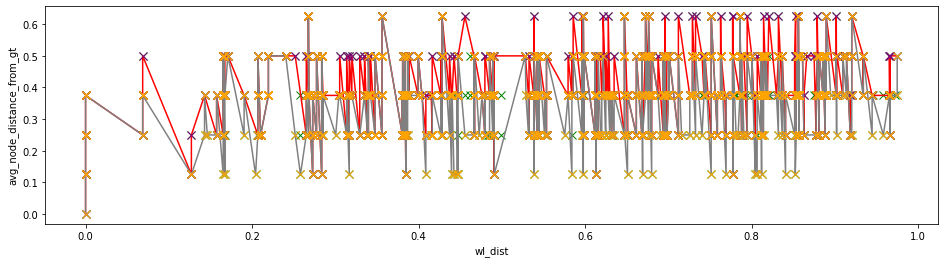

In [24]:
fig, axes = plt.subplots(1, 1, figsize=(16, 4))
axes.plot(x, y, color='orange', marker='x', markersize=8, markerfacecolor='green', markeredgecolor='green', linestyle='')
axes.plot(upper_x, upper_y, color='red', marker='x', markersize=8, markerfacecolor='green', markeredgecolor='purple', linestyle='-')
axes.plot(lower_x, lower_y, color='gray', marker='x', markersize=8, markerfacecolor='green', markeredgecolor='orange', linestyle='-')

plt.xlabel('wl_dist')
plt.ylabel('avg_node_distance_from_gt')

Text(0, 0.5, 'avg_node_distance_from_gt')

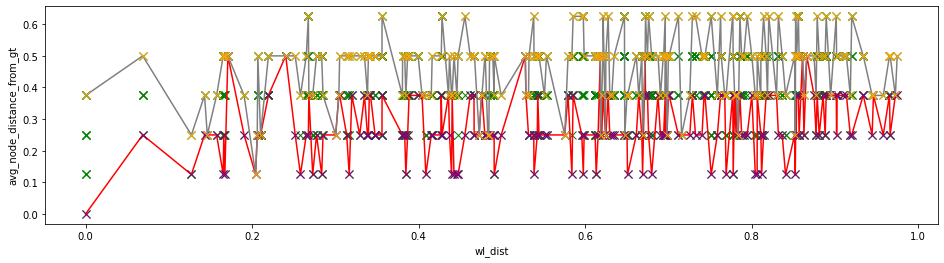

In [25]:

# plt.plot(x, y, color='red', marker='x', markersize=8, markerfacecolor='green', markeredgecolor='green', linestyle='')
# plt.xlabel('wl_dist')
# plt.ylabel('avg_node_distance_from_gt')

fig, axes = plt.subplots(1, 1, figsize=(16, 4))
axes.plot(x, y, color='orange', marker='x', markersize=8, markerfacecolor='green', markeredgecolor='green', linestyle='')
axes.plot(x_unique, y_min, color='red', marker='x', markersize=8, markerfacecolor='green', markeredgecolor='purple', linestyle='-')
axes.plot(x_unique, y_max, color='gray', marker='x', markersize=8, markerfacecolor='green', markeredgecolor='orange', linestyle='-')

plt.xlabel('wl_dist')
plt.ylabel('avg_node_distance_from_gt')

In [26]:
subgraph_masks_colored_full_graphs = []

def color_graph_with_subgraph_mask(graph, subgraph, node_label_name="label"):
    # derive initial colors (node labels) from subgraph mask
    node_to_indicator_value_map = {}
    for node in graph.nodes:
        if node in subgraph.nodes:
            node_to_indicator_value_map[node] = 1
        else:
            node_to_indicator_value_map[node] = 0

    # set full graph node labels
    nx.set_node_attributes(graph, node_to_indicator_value_map, name=node_label_name)

def copy_graph(graph):
    H = graph.__class__()
    H.add_nodes_from(graph)
    H.add_edges_from(graph.edges)
    return H

for subgraph in subgraphs:
    # copy full graph
    H = copy_graph(G)
    color_graph_with_subgraph_mask(H, subgraph, node_label_name)

    subgraph_masks_colored_full_graphs.append(H)

In [27]:
full_graph_coloring_of_target_subgraph = copy_graph(G)

target_subgraph_copy = copy_graph(target_subgraph)
target_subgraph_copy.remove_nodes_from(list(nx.isolates(target_subgraph_copy)))

color_graph_with_subgraph_mask(full_graph_coloring_of_target_subgraph, target_subgraph_copy, node_label_name)

# full_graph_coloring_of_target_subgraph = copy_graph(target_subgraph)
#
# target_subgraph_copy = copy_graph(target_subgraph)
# target_subgraph_copy.remove_nodes_from(list(nx.isolates(target_subgraph_copy)))
#
# color_graph_with_subgraph_mask(full_graph_coloring_of_target_subgraph, target_subgraph_copy, node_label_name)

compute wl embedding for all colored full graphs


In [28]:
colored_full_graphs_distance_matrix = get_graph_wl_distances(subgraph_masks_colored_full_graphs + [full_graph_coloring_of_target_subgraph], node_label=True)

Enforce continous flag is on, using CONTINUOUS propagation scheme.


In [29]:
colored_full_graphs_distance_matrix_vs_target_subgraph_distances = colored_full_graphs_distance_matrix[:-1, -1]

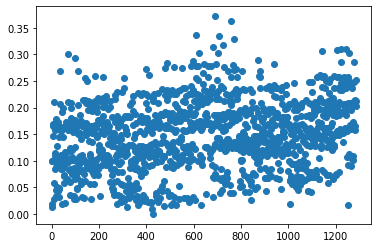

In [30]:
plt.scatter(range(len(colored_full_graphs_distance_matrix_vs_target_subgraph_distances)), colored_full_graphs_distance_matrix_vs_target_subgraph_distances)
plt.show()

In [31]:
#TODO: if not the same number of nodes, the results are not good (that is why we did not remove isolated nodes back then if I remmber)

In [32]:
# igraphs = [Graph() for i in range(len(subgraph_masks_colored_full_graphs))]
# igraphs = [igraph.from_networkx(graph) for igraph, graph in zip(igraphs, subgraph_masks_colored_full_graphs)]
# igraphs[0].vs['label']